### Imports

In [1]:
from zoish.feature_selectors.shap_selectors import ShapFeatureSelector
import pandas as pd
import lightgbm
from sklearn.model_selection import KFold, train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from category_encoders import OrdinalEncoder


In this module the default logging will be applied.


#### Example: Use Adult Data Set (a classification problem)
###### https://archive.ics.uci.edu/ml/datasets/Adult


#### Read data

In [2]:
urldata = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# column names
col_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education-num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "label",
]
# read data
data = pd.read_csv(urldata, header=None, names=col_names, sep=",")
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#### Define labels and train-test split


In [3]:
data.loc[data["label"] == "<=50K", "label"] = 0
data.loc[data["label"] == " <=50K", "label"] = 0

data.loc[data["label"] == ">50K", "label"] = 1
data.loc[data["label"] == " >50K", "label"] = 1

data["label"] = data["label"].astype(int)

# # Train test split

X = data.loc[:, data.columns != "label"]
y = data.loc[:, data.columns == "label"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y["label"], random_state=42
)


#### Define feature selector step 

In [4]:

shap_feature_selector_factory = (
    ShapFeatureSelector.shap_feature_selector_factory.set_model_params(
        X=X_train,
        y=y_train,
        verbose=0,
        random_state=0,
        estimator=lightgbm.LGBMClassifier(),
        estimator_params={
            "boosting_type":['gbdt','dart'],
            "max_depth": [4, 5],
            "reg_lambda":[0.0,1.0],
            "n_estimators":[100,200],
        },
        fit_params ={
            "init_score":None,
        },
        method="randomsearch",
        # if n_features=None only the threshold will be considered as a cut-off of features grades.
        # if threshold=None only n_features will be considered to select the top n features.
        # if both of them are set to some values, the threshold has the priority for selecting features.
        n_features=3,
        threshold= 0.3,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
    )
    .set_shap_params(
        model_output="raw",
        feature_perturbation="interventional",
        algorithm="v2",
        shap_n_jobs=-1,
        memory_tolerance=-1,
        feature_names=None,
        approximate=False,
        shortcut=False,
    )
    .set_randomsearchcv_params(
        measure_of_accuracy=make_scorer(f1_score, greater_is_better=True, average='macro'),
        verbose=0,
        n_jobs=-1,
        cv=KFold(2),
        n_iter=3,
    )
)


#### Find feature type for later use


In [5]:
int_cols = X_train.select_dtypes(include=["int"]).columns.tolist()
float_cols = X_train.select_dtypes(include=["float"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()


#### Define pipeline

In [6]:
pipeline = Pipeline(
    [
        # int missing values imputers
        (
            "intimputer",
            MeanMedianImputer(imputation_method="median", variables=int_cols),
        ),
        # category missing values imputers
        ("catimputer", CategoricalImputer(variables=cat_cols)),
        #
        ("catencoder", OrdinalEncoder()),
        # feature selection
        ("sfsf", shap_feature_selector_factory),
        # classification model
        ("SVC", SVC()),
    ]
)

#### Run Pipeline

In [7]:
pipeline.fit(X_train, y_train.values.ravel())
y_pred = pipeline.predict(X_test)

#### Check performance of the Pipeline

In [8]:

print("F1 score : ")
print(f1_score(y_test, y_pred))
print("Classification report : ")
print(classification_report(y_test, y_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_pred))


F1 score : 
0.2963446475195822
Classification report : 
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      8158
           1       0.95      0.18      0.30      2588

    accuracy                           0.80     10746
   macro avg       0.87      0.59      0.59     10746
weighted avg       0.83      0.80      0.74     10746

Confusion matrix : 
[[8136   22]
 [2134  454]]


#### Plot summary plot for selected features

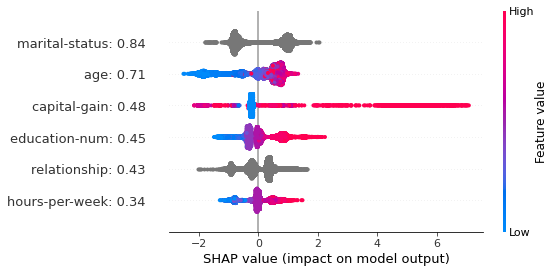

ShapFeatureSelector(X=       age   workclass  fnlwgt      education  education-num  \
3977    24     Private  228649      Bachelors             13   
20418   28     Private  122540           10th              6   
20647   38     Private   81965      Assoc-voc             11   
30435   47     Private  107460        HS-grad              9   
8820    28     Private  302406    Prof-school             15   
...    ...         ...     ...            ...            ...   
4639    30   Local-gov  125159      Bachelors             13   
20560   39     Private  421633   Some-college             10   
23650   55     Private   82098        HS-grad              9   
25301   26     Private   50053      Bachelors             13   
5...
                    list_of_obligatory_features_that_must_be_in_model=[],
                    measure_of_accuracy=make_scorer(f1_score, average=macro),
                    memory_tolerance=-1, method='randomsearch',
                    model_output='raw', n_features=6, n_iter=3, n_jobs=-1,
                    random_state=0, shap_n_jobs=-1, shortcut=False,
                    threshold=0.3, verbose=0,
                    y=       label
3977       0
20418      0
20647      0
30435      0
8820       0
...      ...
4639       1
20560      0
23650      0
25301      0
5800       0

[21815 rows x 1 columns])

In [9]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="summary_plot",
    path_to_save_plot="../plots/random_search_classification_2_summary_plot"
)


#### Plot summary plot for full features

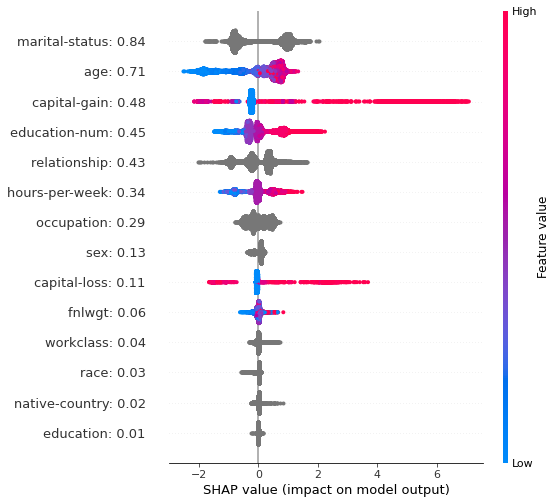

ShapFeatureSelector(X=       age   workclass  fnlwgt      education  education-num  \
3977    24     Private  228649      Bachelors             13   
20418   28     Private  122540           10th              6   
20647   38     Private   81965      Assoc-voc             11   
30435   47     Private  107460        HS-grad              9   
8820    28     Private  302406    Prof-school             15   
...    ...         ...     ...            ...            ...   
4639    30   Local-gov  125159      Bachelors             13   
20560   39     Private  421633   Some-college             10   
23650   55     Private   82098        HS-grad              9   
25301   26     Private   50053      Bachelors             13   
5...
                    list_of_obligatory_features_that_must_be_in_model=[],
                    measure_of_accuracy=make_scorer(f1_score, average=macro),
                    memory_tolerance=-1, method='randomsearch',
                    model_output='raw', n_features=6, n_iter=3, n_jobs=-1,
                    random_state=0, shap_n_jobs=-1, shortcut=False,
                    threshold=0.3, verbose=0,
                    y=       label
3977       0
20418      0
20647      0
30435      0
8820       0
...      ...
4639       1
20560      0
23650      0
25301      0
5800       0

[21815 rows x 1 columns])

In [10]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="summary_plot_full",
    path_to_save_plot="../plots/random_search_classification_2_summary_plot_full"
)


#### Bar plot for selected features

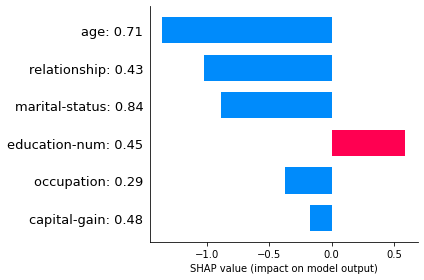

ShapFeatureSelector(X=       age   workclass  fnlwgt      education  education-num  \
3977    24     Private  228649      Bachelors             13   
20418   28     Private  122540           10th              6   
20647   38     Private   81965      Assoc-voc             11   
30435   47     Private  107460        HS-grad              9   
8820    28     Private  302406    Prof-school             15   
...    ...         ...     ...            ...            ...   
4639    30   Local-gov  125159      Bachelors             13   
20560   39     Private  421633   Some-college             10   
23650   55     Private   82098        HS-grad              9   
25301   26     Private   50053      Bachelors             13   
5...
                    list_of_obligatory_features_that_must_be_in_model=[],
                    measure_of_accuracy=make_scorer(f1_score, average=macro),
                    memory_tolerance=-1, method='randomsearch',
                    model_output='raw', n_features=6, n_iter=3, n_jobs=-1,
                    random_state=0, shap_n_jobs=-1, shortcut=False,
                    threshold=0.3, verbose=0,
                    y=       label
3977       0
20418      0
20647      0
30435      0
8820       0
...      ...
4639       1
20560      0
23650      0
25301      0
5800       0

[21815 rows x 1 columns])

In [11]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="bar_plot",
    path_to_save_plot="../plots/random_search_classification_2_bar_plot"
)

#### Bar plot for all features

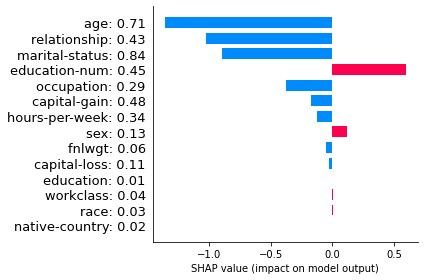

ShapFeatureSelector(X=       age   workclass  fnlwgt      education  education-num  \
3977    24     Private  228649      Bachelors             13   
20418   28     Private  122540           10th              6   
20647   38     Private   81965      Assoc-voc             11   
30435   47     Private  107460        HS-grad              9   
8820    28     Private  302406    Prof-school             15   
...    ...         ...     ...            ...            ...   
4639    30   Local-gov  125159      Bachelors             13   
20560   39     Private  421633   Some-college             10   
23650   55     Private   82098        HS-grad              9   
25301   26     Private   50053      Bachelors             13   
5...
                    list_of_obligatory_features_that_must_be_in_model=[],
                    measure_of_accuracy=make_scorer(f1_score, average=macro),
                    memory_tolerance=-1, method='randomsearch',
                    model_output='raw', n_features=6, n_iter=3, n_jobs=-1,
                    random_state=0, shap_n_jobs=-1, shortcut=False,
                    threshold=0.3, verbose=0,
                    y=       label
3977       0
20418      0
20647      0
30435      0
8820       0
...      ...
4639       1
20560      0
23650      0
25301      0
5800       0

[21815 rows x 1 columns])

In [12]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="bar_plot_full",
    path_to_save_plot="../plots/random_search_classification_2_bar_plot_full"
)

#### Decision plot for selected features (not more than samples can be used !)

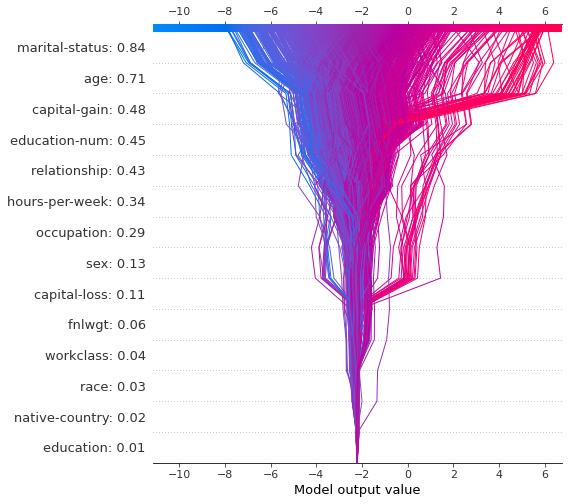

ShapFeatureSelector(X=       age   workclass  fnlwgt      education  education-num  \
3977    24     Private  228649      Bachelors             13   
20418   28     Private  122540           10th              6   
20647   38     Private   81965      Assoc-voc             11   
30435   47     Private  107460        HS-grad              9   
8820    28     Private  302406    Prof-school             15   
...    ...         ...     ...            ...            ...   
4639    30   Local-gov  125159      Bachelors             13   
20560   39     Private  421633   Some-college             10   
23650   55     Private   82098        HS-grad              9   
25301   26     Private   50053      Bachelors             13   
5...
                    list_of_obligatory_features_that_must_be_in_model=[],
                    measure_of_accuracy=make_scorer(f1_score, average=macro),
                    memory_tolerance=-1, method='randomsearch',
                    model_output='raw', n_features=6, n_iter=3, n_jobs=-1,
                    random_state=0, shap_n_jobs=-1, shortcut=False,
                    threshold=0.3, verbose=0,
                    y=       label
3977       0
20418      0
20647      0
30435      0
8820       0
...      ...
4639       1
20560      0
23650      0
25301      0
5800       0

[21815 rows x 1 columns])

In [13]:
ShapFeatureSelector.shap_feature_selector_factory.plot_features_all(
    type_of_plot="decision_plot",
    path_to_save_plot="../plots/random_search_classification_2_decision_plot"
)

#### Get list of features and grades

In [14]:
ShapFeatureSelector.shap_feature_selector_factory.get_info_of_features_and_grades()

list of selected features+list of obligatory features that must be in model-list of features to drop before any selection               ['hours-per-week', 'marital-status', 'capital-gain', 'age', 'education-num', 'relationship']
list of selected features and their grades
---------------------------------------------------------
       column_name feature_importance
5   marital-status           0.842457
0              age           0.713062
10    capital-gain           0.482606
4    education-num           0.446358
7     relationship           0.434377
12  hours-per-week           0.339542
Note: list of obligatory features that must be in model-list of features to drop before any selection also has considered !


ShapFeatureSelector(X=       age   workclass  fnlwgt      education  education-num  \
3977    24     Private  228649      Bachelors             13   
20418   28     Private  122540           10th              6   
20647   38     Private   81965      Assoc-voc             11   
30435   47     Private  107460        HS-grad              9   
8820    28     Private  302406    Prof-school             15   
...    ...         ...     ...            ...            ...   
4639    30   Local-gov  125159      Bachelors             13   
20560   39     Private  421633   Some-college             10   
23650   55     Private   82098        HS-grad              9   
25301   26     Private   50053      Bachelors             13   
5...
                    list_of_obligatory_features_that_must_be_in_model=[],
                    measure_of_accuracy=make_scorer(f1_score, average=macro),
                    memory_tolerance=-1, method='randomsearch',
                    model_output='raw', n_features=6, n_iter=3, n_jobs=-1,
                    random_state=0, shap_n_jobs=-1, shortcut=False,
                    threshold=0.3, verbose=0,
                    y=       label
3977       0
20418      0
20647      0
30435      0
8820       0
...      ...
4639       1
20560      0
23650      0
25301      0
5800       0

[21815 rows x 1 columns])

#### Only list of selected features is :

In [15]:
print(ShapFeatureSelector.shap_feature_selector_factory.get_list_of_features())

['hours-per-week', 'marital-status', 'capital-gain', 'age', 'education-num', 'relationship']
